In [1]:
from stylelib import *
from process_helper import *

In [2]:
path = "/Users/scarlet/Documents/GitHub/Sundial/outputs/"
# path = "E:/Research_E/Sundial/outputs/"
paper_path = "../main/figures/"
paper_path = "new_figures/"
storage = "blob_iso"
selectby = "median"
unit = "ms"

## 0. Select Color Scheme

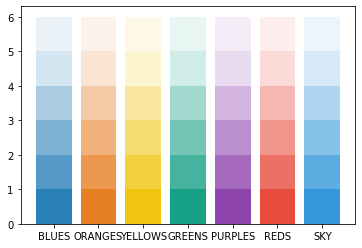

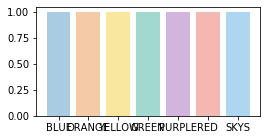

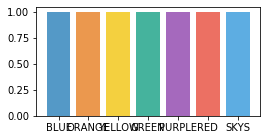

<Figure size 288x144 with 0 Axes>

In [3]:
_, grad_colors = display_colors()
_, bar_colors = select_color_idx(2)
_, line_colors = select_color_idx(4)

In [4]:
C_1PC

'ORANGE'

In [5]:
C_2PC

'BLUE'

In [6]:
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.5

## 2. read ratio
### 1) import & preprocess data

In [7]:
exp = "%s_ro_txn"%storage
x = "perc_readonly_txns"
dfs = [pd.read_csv(path+"read_perc_{}{}_concat.csv".format(storage, i)) for i in [""]]
df = concat(dfs)
# calculate percentage of read only txn
df[x] = (pow(df["READ_PERC"], 16)) * 100
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
agg_single_latency = process_latency(x, df, latency_type="single_part_latency", select=agg_latency)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with median AGG_average_dist_latency


### 2) Latency

speedup: [1.03543115 0.90230402 0.79834801 0.59232008 0.52393537]


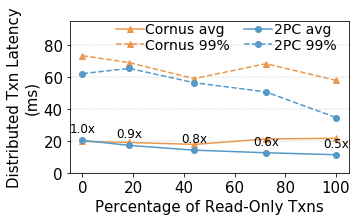

In [9]:
data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_latency(x, data, ys=y_agg_dist_latency, 
                            xlabel="Percentage of Read-Only Txns",
                            plot_speedup=True, speedup_yspace=5, speedup_xspace=-5,
                            line_colors=line_colors, ylim=1.3, unit=unit)
ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%"], loc='upper right', 
          ncol=2, prop={'size': 14}, labelspacing=0.1, columnspacing=1, handletextpad=0.1, frameon=False,
          bbox_to_anchor=(1,1.07))
ax.set_ylabel("Distributed Txn Latency\n(%s)"%unit)
plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

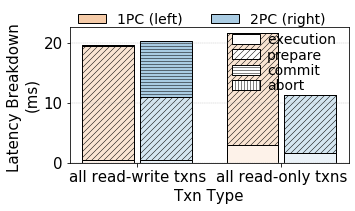

In [10]:
zipper = zip([0, 100], [y_multi_part_latency, y_multi_part_latency])
xcate = ["all read-write txns", "all read-only txns"]
fig, ax = plot_breakdown(x, zipper, xcate, bar_colors, grad_colors, how=None, 
                         agg_multi_latency=agg_multi_latency, ylim=2)
labels = ["execution", "prepare", "commit", "abort"]
ax.legend(get_pattern_patches(labels, ALL_PATTERNS), labels,prop={'size': 14}, 
          loc='upper right', ncol=1, labelspacing=0.1, bbox_to_anchor=(1,1.05),
          columnspacing=0, handletextpad=0.5, frameon=False)
plt.savefig(paper_path+exp+"_breakdown_({}_latency).pdf".format(selectby), bbox_inches="tight")

## 4. Contention

### 4.1 YCSB - Zipfian

In [13]:
exp = "%s_zipf"%storage
x = "ZIPF_THETA"
dfs = [pd.read_csv(path+"zipf_{}{}_concat.csv".format(storage, i)) for i in [""]]
df = concat(dfs)
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with median AGG_average_dist_latency


KeyError: 10

In [18]:
df.groupby(["COMMIT_ALG","ZIPF_THETA"])[y_agg_latency].median()

average_latency  99%_latency
COMMIT_ALG ZIPF_THETA                              
ONE_PC     0.00               0.018555     0.060672
           0.30                    NaN          NaN
           0.50                    NaN          NaN
           0.70                    NaN          NaN
           0.90                    NaN          NaN
           0.99                    NaN          NaN
TWO_PC     0.00               0.014722     0.055473
           0.30               0.014883     0.058489
           0.50               0.015176     0.065096
           0.70               0.015274     0.057544
           0.90               0.027367     0.163551
           0.99               0.054876     0.297226

### 2) Latency

speedup: [1.75177801 1.81669295 1.78633136 1.70340191 1.78875616 1.22646602]


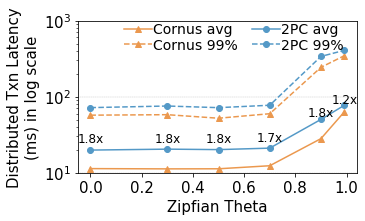

In [56]:
data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_latency(x, data, ys=y_agg_dist_latency, 
                            xlabel="Zipfian Theta",
                            plot_speedup=True, speedup_yspace=5, speedup_xspace=-0.05,
                            line_colors=line_colors, ylim=1.01, unit="ms")
ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%"], loc='upper right', 
          ncol=2, prop={'size': 14}, labelspacing=0.1, columnspacing=1, handletextpad=0.1, frameon=False,
          bbox_to_anchor=(1,1.07))
ax.set_ylabel("Distributed Txn Latency\n(%s) in log scale"%unit)
plt.yscale("log")
plt.ylim((10,1000))
plt.savefig(paper_path+exp+"_latency_({}_latency)_log_scale.pdf".format(selectby), bbox_inches="tight")

### 3) breakdown

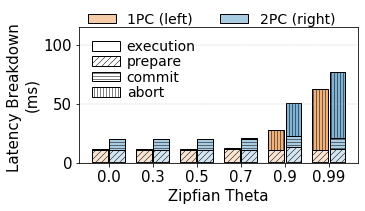

In [52]:
xcate = data[x].unique()
zipper = zip(xcate, [y_multi_part_latency]*len(xcate))
fig, ax = plot_breakdown(x, zipper, xcate, bar_colors, grad_colors, how=None, agg_multi_latency=agg_multi_latency)
plt.xticks(np.array([0, 0.5, 1, 1.5, 2, 2.5]), xcate)
#ax.set_yscale('log')
ax.set_xlabel("Zipfian Theta")
plt.savefig(paper_path+exp+"_breakdown_({}_latency).pdf".format(selectby), bbox_inches="tight")

## 5. Scalability

In [11]:
exp = "%s_scalability"%storage
x = "NUM_NODES"
dfs = [pd.read_csv(path+"num_nodes_{}{}_concat.csv".format(storage, i)) for i in [""]]
df = concat(dfs)
# agg: "latency" or "Throughput"
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
#agg_single_latency = process_latency(x, df, latency_type="single_part_latency", select=agg_latency)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)

selected trial with median AGG_average_dist_latency


In [12]:
df.groupby(["COMMIT_ALG", "NUM_NODES"])["NODE_ID"].count()

COMMIT_ALG  NUM_NODES
ONE_PC      2            11
            4            20
            6            35
            8            40
TWO_PC      2            10
            4            23
            6            30
            8            40
Name: NODE_ID, dtype: int64

### 2) Latency

speedup: [0.9858804  0.8841999  0.85148152 0.82819143]


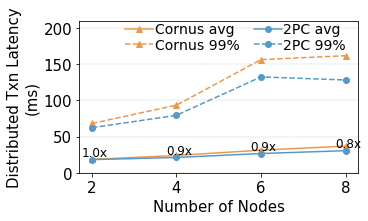

In [13]:
data = agg_latency.sort_values(by=x)
fig, ax, ax2 = plot_latency(x, data, ys=y_agg_dist_latency, 
                            xlabel="Number of Nodes",
                            plot_speedup=True, speedup_yspace=5, speedup_xspace=-0.25,
                            line_colors=line_colors, ylim=1.3, unit="ms")
ax.legend(["Cornus avg", "Cornus 99%", "2PC avg", "2PC 99%"], loc='upper right', 
          ncol=2, prop={'size': 14}, labelspacing=0.1, columnspacing=1, handletextpad=0.1, frameon=False,
          bbox_to_anchor=(1,1.07))
ax.set_ylabel("Distributed Txn Latency\n(ms)")
plt.savefig(paper_path+exp+"_latency_({}_latency).pdf".format(selectby), bbox_inches="tight")

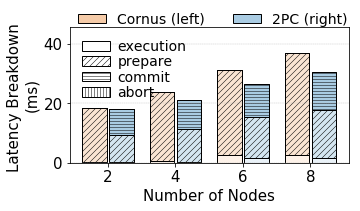

In [14]:
xcate = data[x].unique()
zipper = zip(xcate, [y_multi_part_latency]*len(xcate))
fig, ax = plot_breakdown(x, zipper, xcate, bar_colors, grad_colors, how=None, agg_multi_latency=agg_multi_latency)
# plt.xticks(np.array([0, 0.5, 1, 1.5, 2, 2.5]), xcate)
#ax.set_yscale('log')
ax.set_xlabel("Number of Nodes")
plt.savefig(paper_path+exp+"_breakdown_({}_latency).pdf".format(selectby), bbox_inches="tight")

In [24]:
## PROCESS DATA
algs = ["ONE_PC", "TWO_PC"]
## PROCESS REQUEST TYPES
df.columns = [i.replace(" ", "") if ("req_latency" in i  or "log" in i) else i for i in df.columns.values]
df = df.replace("nan", np.nan).dropna(how="all", axis=1)
## PRINT PROFILING STATS
logging_stats = ["average_" + i for i in [
    "log_if_ne", 
    "log_if_ne_data", 
    "log_sync",
    "log_async",
    "log_sync_data",
    "log_async_data",
    "log_if_ne_iso", 
    "log_if_ne_data_iso",
    "log_sync_data_iso",
    "log_async_data_iso"
]]
grpc_stats = ["average_"+i for i in [
    "log_vote_pa", 
    "log_commit_co",
    "node_communicate"
]] + [i for i in df.columns if "req_latency" in i and "average" in i]
if "blob" in storage:
    meta_col = logging_stats + grpc_stats
else:
    meta_col = grpc_stats
table = []
# column: 1pc, 2pc
# row: zipf, phase
agg_throughput, agg_latency = aggregate(x, df, latency_type="dist_latency", agg="latency", how=selectby)
agg_single_latency = process_latency(x, df, latency_type="single_part_latency", select=agg_latency)
agg_multi_latency = process_latency(x, df, latency_type="multi_part_latency", select=agg_latency)
data = agg_multi_latency
metrics = [col for col in data.columns if "us" in col]
# prefix
prefix = {
    "execute_phase": "00-",
    "prepare_phase": "01-",
    "commit_phase": "02-",
    "abort": "03-",
}
for j, mt in enumerate(meta_col):
    if j + 4 < 10:
        prefix[mt] = "0%d-"%(j+4)
    else:
        prefix[mt] = "%d-"%(j+4)
# reformat
scale = 1 # default unit is us
if unit == "ms":
    scale = 1000
elif unit == "s":
    scale = 1000000
for i in range(data.shape[0]):
    row = data.loc[i, :]
    for m in metrics:
        m_name = m.split("AGG_multi_part_")[-1].split("(")[0].strip()
        new_row = {
            "phase": prefix[m_name]+m_name+" (%s)"%unit, 
            "x": data.loc[i,x],
            "instance": data.loc[i,"i"],
            "measure": "%.2f" %(data.loc[i,m] / scale),
            "commit_alg": data.loc[i, "COMMIT_ALG"]
        }
        table.append(new_row)
    for mt in meta_col:
        if mt not in df:
            continue
        meta = apply_mask(df, [("COMMIT_ALG", data.loc[i, "COMMIT_ALG"]),
                ("i", new_row["instance"]),
                (x, data.loc[i,x]),
               ])[mt].mean() 
        new_row = {
                "phase": prefix[mt]+mt+" (%s)"%unit, 
                "x": data.loc[i,x],
                "instance": data.loc[i,"i"],
                "measure": "%.2f" %(meta / scale),
                "commit_alg": data.loc[i, "COMMIT_ALG"]
        }
        table.append(new_row)
table = pd.DataFrame(data=table)
stats = pd.pivot_table(table, values='measure', index=["x", "commit_alg"],
                columns=["phase"], aggfunc=np.sum).dropna(how="all", axis=1)
stats.reset_index().to_csv(paper_path+exp+"_profiling.csv", index=False)
f = open(paper_path+exp+"_profiling.txt", "w+")
for alg in algs:
    line = "=== {} ===".format(alg)
    f.write(line+"\n")
    for c in stats.columns:
        data = apply_mask(stats.reset_index(),[("commit_alg", alg)])
        avg_val = np.nanmean(data.loc[:,c].values.astype("float"))
        max_val = np.max(data.loc[:,c].values.astype("float"))
        min_val = np.min(data.loc[:,c].values.astype("float"))
        line = ("%s (in %s): average = %.2f , min = %.2f, max = %.2f "%(c, unit, avg_val, min_val, max_val))
        f.write(line+"\n")


selected trial with median AGG_average_dist_latency


/Users/scarlet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


In [68]:
## 6. Termination Time

In [71]:
exp = "%s_failure_num_nodes" % storage
x = "NUM_NODES"
dfs = [pd.read_csv(path+"failure_num_nodes_{}{}_concat.csv".format(storage, i)) for i in ["", "_repeated"]]
df = concat(dfs)

/Users/scarlet/Documents/GitHub/Paper-1PC/analysis/process_helper.py:87: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dfs, ignore_index=True)


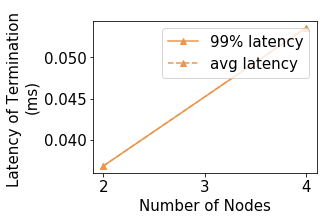

In [75]:
# group by x
# aggregate terminate_time_co by avg
# aggregate num_affected_txn_co by sum
data = df.groupby(x).agg({
    "num_affected_txn_co": "sum",
    "average_term_latency_co": "median",
    "median_term_latency": "median",
    "99%_term_latency": "median"
})
if unit == "ms":
    scale = 1000
elif unit == "us":
    scale = 1000000
else:
    scale = 1
fig, ax = plt.subplots()
# ax.bar(data.index.values, 
#        data["average_term_latency_co"] * scale, 
#        color=tuple(list(ORANGES[3])[:3]+[1]), edgecolor="black")
ax.plot(data["average_term_latency_co"] * scale, color=line_colors[C_1PC], marker="^", linestyle="-")
ax.plot(data["99%_term_latency"] * scale, color=line_colors[C_1PC], marker="^", linestyle="--")
plt.legend(["99% latency", "avg latency"])
fig.set_size_inches(4, 2.8)
plt.xlabel("Number of Nodes")
plt.ylabel("Latency of Termination \n(%s)"%unit)
plt.savefig(paper_path+exp+"_({}_latency).pdf".format(selectby), bbox_inches="tight")